In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


In [2]:
!pip install preprocessing --upgrade
!pip install spacy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 46.6 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.4
    Uninstalling spacy-3.5.4:
      Successfully uninstalled spacy-3.5.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-lg 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.6.1 which is incompatible.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.6.1 which is incompatible.


In [3]:
!python -m spacy download en_core_web_md

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
import warnings
warnings.simplefilter("ignore", ResourceWarning)

## Let's load the training data

In [5]:
summary_df = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
prompt_df = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')

## Check dataframe description

In [6]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  7165 non-null   object 
 1   prompt_id   7165 non-null   object 
 2   text        7165 non-null   object 
 3   content     7165 non-null   float64
 4   wording     7165 non-null   float64
dtypes: float64(2), object(3)
memory usage: 280.0+ KB


In [7]:
prompt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        4 non-null      object
 1   prompt_question  4 non-null      object
 2   prompt_title     4 non-null      object
 3   prompt_text      4 non-null      object
dtypes: object(4)
memory usage: 256.0+ bytes


## Primary key to combine dataframe on

In [8]:
prompt_df['prompt_id'].unique()

array(['39c16e', '3b9047', '814d6b', 'ebad26'], dtype=object)

In [9]:
summary_df['prompt_id'].unique()

array(['814d6b', 'ebad26', '3b9047', '39c16e'], dtype=object)

## Merge dataframe based on primary key into one

In [10]:
train_df = summary_df.merge(right=prompt_df,how='inner', on='prompt_id')

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 503.8+ KB


### Let's perform a little exploratory analysis on the data to see what samples looks like

In [12]:
print('''Question: %s \n 
Title: %s \n
Text: %s'''%(train_df.iloc[1]['prompt_question'],train_df.iloc[1]['prompt_title'],train_df.iloc[1]['prompt_text']))

Question: Summarize how the Third Wave developed over such a short period of time and why the experiment was ended. 
 
Title: The Third Wave 

Text: Background 
The Third Wave experiment took place at Cubberley High School in Palo Alto, California during the first week of April 1967. History teacher Ron Jones, finding himself unable to explain to his students how people throughout history followed the crowd even when terrible things were happening, decided to demonstrate it to his students through an experiment. Jones announced that he was starting a movement aimed to eliminate democracy. Jones named the movement “The Third Wave” as a symbol of strength, referring to the mythical belief that the third in a series of waves is the strongest. One of the central points of this movement was that democracy’s main weakness is that it favors the individual over the whole community. Jones emphasized this main point of the movement when he created this catchy motto: “Strength through discipline,

### Let's check what the student summary looks like

In [13]:
from pprint import pformat
print(pformat('''Question: %s
Summary: %s
Content Score: %s
Wording Score: %s'''%(train_df.iloc[0]['prompt_question'],train_df.iloc[0]['text'], train_df.iloc[0]['content'],
                           train_df.iloc[0]['wording'])))

('Question: Summarize how the Third Wave developed over such a short period of '
 'time and why the experiment was ended.\n'
 'Summary: The third wave was an experimentto see how people reacted to a new '
 'one leader government. It gained popularity as people wanted to try new '
 'things. The students follow anything that is said and start turning on '
 'eachother to gain higher power. They had to stop the experement as too many '
 'people got to radical with it blindly following there leader\n'
 'Content Score: 0.205682506482641\n'
 'Wording Score: 0.380537638762288')


## Let's build a helper function that displays N text in a pretty format

In [14]:
def display_text(s=1,n=10,df=train_df):
    """
    This function takes n as input and displays n section of text
    """
    for i in range(s,n):
        p_sum = pformat('''Question: %s \nSummary: %s \nContent Score: %s \nWording Score: %s'''%(df.iloc[i]['prompt_question'],df.iloc[i]['text'], df.iloc[i]['content'],
                           df.iloc[i]['wording']))
        print(p_sum,end='\n\n')

In [15]:
display_text(s=200,n=220,df=train_df)

('Question: Summarize how the Third Wave developed over such a short period of '
 'time and why the experiment was ended. \n'
 'Summary: The Third Wave developed over such a short period of time. Jones '
 'emphasized many simple rules and made sure the students did it right. '
 'Students also had to salute each other in a specific way that the teacher '
 'had made. On the fourth day, Jones claimed that things started getting out '
 'of control because the students became increasingly involved in the project, '
 'so their discipline and loyalty to the project was overly outstanding. So '
 'Jones decided to terminate the movement and lied to the students by '
 'announcing that the Third Wave was a part of a nationwide movement.  \n'
 'Content Score: 1.46743085810556 \n'
 'Wording Score: 1.84017156306968')

('Question: Summarize how the Third Wave developed over such a short period of '
 'time and why the experiment was ended. \n'
 'Summary: It happened so fastly because the orig nail kid

#### Combine the Title, Question, Context and Summary text into one large block of text

In [16]:
sample = 'Title:\n'+train_df.iloc[0]['prompt_title']+'\nQuestion:\n'+train_df.iloc[0]['prompt_question']+'\nText:\n'+train_df.iloc[0]['prompt_text']+'\nAnswer:\n'+train_df.iloc[0]['text']

In [17]:
print(sample)

Title:
The Third Wave
Question:
Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.
Text:
Background 
The Third Wave experiment took place at Cubberley High School in Palo Alto, California during the first week of April 1967. History teacher Ron Jones, finding himself unable to explain to his students how people throughout history followed the crowd even when terrible things were happening, decided to demonstrate it to his students through an experiment. Jones announced that he was starting a movement aimed to eliminate democracy. Jones named the movement “The Third Wave” as a symbol of strength, referring to the mythical belief that the third in a series of waves is the strongest. One of the central points of this movement was that democracy’s main weakness is that it favors the individual over the whole community. Jones emphasized this main point of the movement when he created this catchy motto: “Strength through discipline, stre

In [18]:
train_df['full_text'] = train_df.apply(lambda x: 'Title:\n'+x['prompt_title']+
               '\nQuestion:\n'+x['prompt_question']+
               '\nText:\n'+x['prompt_text']+
               '\nAnswer:\n'+x['text'],axis=1)

### Make a copy of the dataframe

In [19]:
df = train_df[['student_id','full_text','content','wording']].copy()

### Let's perform text preprocessing on our df full_text column

In [20]:
import warnings
warnings.simplefilter("ignore", UserWarning)

### Input all libraries

In [21]:
import spacy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV

In [22]:
from string import punctuation as punc
from collections import defaultdict
import spacy
from string import punctuation as punc
from tqdm import tqdm

nlp = spacy.load("en_core_web_md")

def process_text(text):
    doc = nlp(text)
    lemmas = []
    stops = 0
    non_stops = 0

    for token in doc:
        if token.is_stop:
            stops += 1
        else:
            lemmas.append(token.lemma_.lower())
            non_stops += 1

    return ' '.join(lemmas), stops, non_stops

def count_punc(text):
    return len([p for p in text if p in punc])

def get_pos_counts(text):
    doc = nlp(text)
    pos = defaultdict(int)
    for token in doc:
        if not token.is_stop:
            pos[token.pos_] += 1
    return dict(pos)  # Convert back to a regular dictionary for consistency with the original code

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preprocess_data(summary_df, prompt_df, ngram_range=(1,1)):
    train_df = summary_df.merge(right=prompt_df, how='inner', on='prompt_id')

    train_df = train_df.assign(
        summary_text='Context:\n' + train_df['prompt_text'] +
                     '\nAnswer:\n' + train_df['text']
    )
    
    print('processing summary text......')
    # Process the texts using tqdm for a progress bar
    processed_data = []
    for text in tqdm(train_df['text'],desc='processing summary text'):
        lemmas, stops, non_stops = process_text(text)
        processed_data.append((lemmas, stops, non_stops))
        
    print('processing full text......')
    full_processed_data = []
    for text in tqdm(train_df['summary_text'],desc='processing full text'):
        lemmas, stops, non_stops = process_text(text)
        full_processed_data.append((lemmas, stops, non_stops))
        

    _, train_df['summary_stopwords'], train_df['summary_length_without_stops'] = zip(*processed_data)
    train_df['full_text'], _, _ = zip(*full_processed_data)

    print('processing features.....')
    # Process other columns
    data = [get_pos_counts(text) for text in summary_df['text']]
    pos = pd.DataFrame(data).fillna(0).values
    train_df['length_of_summary'] = train_df['text'].str.count(' ') + 1
    train_df['context_stopwords'] = train_df['prompt_text'].apply(lambda x: process_text(x)[1])
    train_df['length_of_context'] = train_df['prompt_text'].str.count(' ') + 1
    train_df['summary_punctuation'] = train_df['text'].apply(count_punc)

    cols = ['student_id', 'full_text', 'summary_text', 'length_of_summary', 'summary_length_without_stops',
            'context_stopwords', 'length_of_context', 'summary_stopwords', 'summary_punctuation',
            'content', 'wording']

    print('applying vectorizer.....')
    global transformer, vectorizer
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    transformer = TfidfTransformer()
    transformed_df = transformer.fit_transform(vectorizer.fit_transform(train_df['full_text']))

    print('scaling features.....')
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_summary_scaled = scaler.fit_transform(transformed_df.toarray())

    print('decomposing features.......')
    pca = PCA(n_components=2208)
    summary_bag = pca.fit_transform(X_summary_scaled)
    stacked_bag = np.hstack((summary_bag,pos,train_df[cols[3:]].values))

    print('collecting outputs.........')
    student_ids = train_df['student_id'].values

    return stacked_bag, student_ids

In [24]:
import time

start_time = time.time()
bag_of_words, ids = preprocess_data(summary_df,prompt_df,ngram_range=(1,1))

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Code executed in: {elapsed_time:.2f} seconds")

processing summary text......


processing summary text: 100%|██████████| 7165/7165 [02:41<00:00, 44.36it/s]


processing full text......


processing full text: 100%|██████████| 7165/7165 [18:19<00:00,  6.51it/s]


processing features.....
applying vectorizer.....
scaling features.....
decomposing features.......
collecting outputs.........
Code executed in: 2486.74 seconds


In [25]:
bag_of_words.shape

(7165, 2234)

In [26]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,5)

In [27]:
def get_plot(d_lower,d_higher,cumsum):
    fig, axis = plt.subplots()
    axis.step(range(len(cumsum)),cumsum, where='mid', c='b', label='Explained Ration')
    axis.vlines(d_higher, 0, cumsum[d_higher], colors='orange', linestyles='--',label=f'{d_higher} components')
    axis.vlines(d_lower, 0, cumsum[d_lower],colors='red', linestyles='--', label=f'{d_lower} components')
    axis.hlines(cumsum[d_higher], -200, d_higher, colors='orange', linestyles='--', label=f'{cumsum[d_higher]:.2f} cumsum')
    axis.hlines(cumsum[d_lower], -200, d_lower,colors='red', linestyles='--', label=f'{cumsum[d_lower]:.2f} cumsum')
    axis.set_xlim([-200, 5000])
    axis.set_xlabel('Principal Components Index')
    axis.set_ylabel('Explained Variance Ratio')
    axis.grid(True)
    plt.legend(loc='best')
    plt.show()

In [28]:
# get_plot(d_lower=d_95,d_higher=d_99,cumsum=cumsum)

In [29]:
X_train,X_test,y_train,y_test = train_test_split(bag_of_words[:,:-2] ,bag_of_words[:,-2:],test_size=0.1,shuffle=True,random_state=11)

In [30]:
from warnings import filterwarnings
filterwarnings(action='always')

In [31]:
# import tensorflow_decision_forests as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM, Input
from tensorflow.keras.models import Sequential

In [32]:
f_shape = X_train.shape[1]
batch_size = 32

In [33]:
def expand_dims(features, labels):
    features = tf.expand_dims(features, axis=0)
    features = tf.cast(features, tf.float32, name='input_features')
    labels = tf.cast(labels, tf.float32, name='labels')
    return {'input_features':features}, labels

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
dataset = dataset.map(expand_dims,num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
dataset = dataset.cache()
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(X_train.shape[0])
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [35]:
dataset.element_spec

({'input_features': TensorSpec(shape=(32, 1, 2232), dtype=tf.float32, name=None)},
 TensorSpec(shape=(32, 2), dtype=tf.float32, name=None))

In [36]:
def build_model():
    model = Sequential([
        Input(shape=(None,f_shape),batch_size=batch_size,name='input_features',dtype=tf.float32),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,activation='relu',return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,activation='relu')),
        tf.keras.layers.Dropout(0.2),
        Dense(32,activation='relu'),
        Dense(16, activation='relu'),
        Dense(2, activation='relu')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
                 loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
    return model

In [37]:
model = build_model()

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (32, None, 256)          2417664   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (32, 128)                164352    
 nal)                                                            
                                                                 
 dropout (Dropout)           (32, 128)                 0         
                                                                 
 dense (Dense)               (32, 32)                  4128      
                                                                 
 dense_1 (Dense)             (32, 16)                  528       
                                                                 
 dense_2 (Dense)             (32, 2)                   3

In [39]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_dataset = val_dataset.map(expand_dims,num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(100000)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [40]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 2e-8 * 10**(epoch / 10))

In [41]:
history = model.fit(dataset,validation_data=val_dataset,epochs=100,callbacks=[lr_schedule,early_stopping])

Epoch 1/100
201/201 [==============================] - 13s 19ms/step - loss: 1.3568 - mse: 1.3568 - val_loss: 1.3649 - val_mse: 1.3649 - lr: 2.0000e-08
Epoch 2/100
201/201 [==============================] - 2s 12ms/step - loss: 1.3557 - mse: 1.3557 - val_loss: 1.3618 - val_mse: 1.3618 - lr: 2.5179e-08
Epoch 3/100
201/201 [==============================] - 2s 12ms/step - loss: 1.3600 - mse: 1.3600 - val_loss: 1.3580 - val_mse: 1.3580 - lr: 3.1698e-08
Epoch 4/100
201/201 [==============================] - 2s 12ms/step - loss: 1.3528 - mse: 1.3528 - val_loss: 1.3533 - val_mse: 1.3533 - lr: 3.9905e-08
Epoch 5/100
201/201 [==============================] - 3s 12ms/step - loss: 1.3513 - mse: 1.3513 - val_loss: 1.3474 - val_mse: 1.3474 - lr: 5.0238e-08
Epoch 6/100
201/201 [==============================] - 3s 12ms/step - loss: 1.3377 - mse: 1.3377 - val_loss: 1.3400 - val_mse: 1.3400 - lr: 6.3246e-08
Epoch 7/100
201/201 [==============================] - 2s 12ms/step - loss: 1.3397 - mse: 1.3

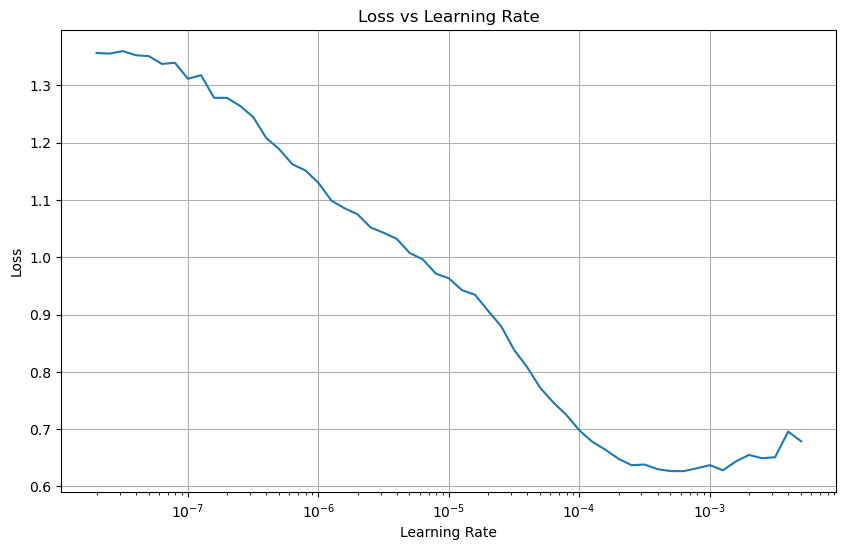

In [42]:
import matplotlib.pyplot as plt

# Extract learning rates and losses from the training history
lrs = history.history['lr']
losses = history.history['loss']

plt.figure(figsize=(10, 6))
plt.semilogx(lrs, losses)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs Learning Rate')
plt.grid(True)
plt.show()


In [43]:
def build_model():
    model = Sequential([
        Input(shape=(None,f_shape),batch_size=batch_size,name='input_features',dtype=tf.float32),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,activation='relu',return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,activation='relu',return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,activation='relu')),
        Dense(64,activation='relu'),
        Dense(16, activation='relu'),
        Dense(2, activation='tanh')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
                 loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
    return model

In [44]:
model = build_model()

In [45]:
history = model.fit(dataset,validation_data=val_dataset,batch_size=batch_size,epochs=100,callbacks=[early_stopping])

Epoch 1/100
201/201 [==============================] - 14s 22ms/step - loss: 0.6202 - mse: 0.6202 - val_loss: 0.4783 - val_mse: 0.4783
Epoch 2/100
201/201 [==============================] - 3s 17ms/step - loss: 0.4813 - mse: 0.4813 - val_loss: 0.4748 - val_mse: 0.4748
Epoch 3/100
201/201 [==============================] - 3s 17ms/step - loss: 0.4422 - mse: 0.4422 - val_loss: 0.4499 - val_mse: 0.4499
Epoch 4/100
201/201 [==============================] - 3s 16ms/step - loss: 0.4193 - mse: 0.4193 - val_loss: 0.4837 - val_mse: 0.4837
Epoch 5/100
201/201 [==============================] - 4s 17ms/step - loss: 0.4063 - mse: 0.4063 - val_loss: 0.4514 - val_mse: 0.4514
Epoch 6/100
201/201 [==============================] - 4s 21ms/step - loss: 0.3791 - mse: 0.3791 - val_loss: 0.4441 - val_mse: 0.4441
Epoch 7/100
201/201 [==============================] - 3s 16ms/step - loss: 0.3659 - mse: 0.3659 - val_loss: 0.4434 - val_mse: 0.4434
Epoch 8/100
201/201 [==============================] - 3s 17m

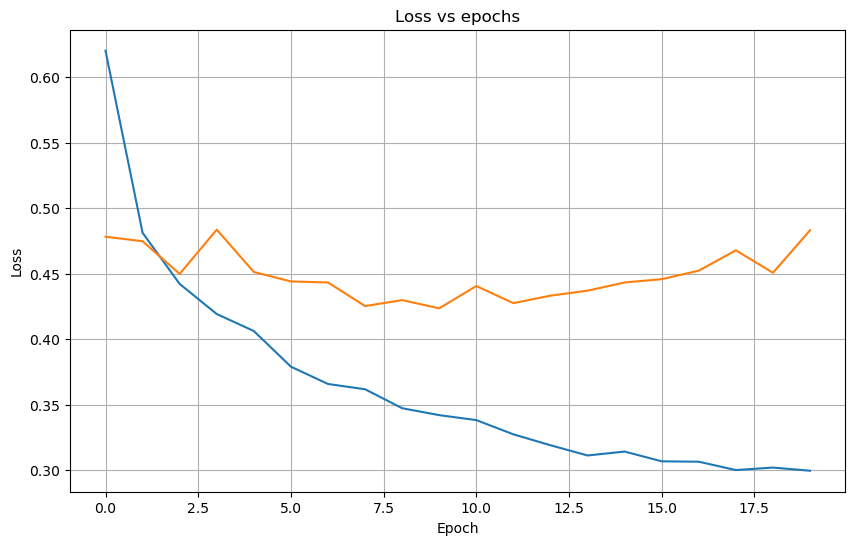

In [46]:
import matplotlib.pyplot as plt

# Extract learning rates and losses from the training history
epochs = range(len(history.history['loss']))
losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses)
plt.plot(epochs, val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.grid(True)
plt.show()

In [47]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_dataset = val_dataset.map(expand_dims,num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(batch_size=1, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [48]:
val_dataset.element_spec

({'input_features': TensorSpec(shape=(1, 1, 2232), dtype=tf.float32, name=None)},
 TensorSpec(shape=(1, 2), dtype=tf.float32, name=None))

In [49]:
preds = model.predict(val_dataset)

717/717 [==============================] - 4s 5ms/step


In [50]:
preds.shape, y_test.shape

((717, 2), (717, 2))

In [51]:
def mcrmse(y_true, y_pred):
    return np.mean(np.sqrt(np.mean((y_true - y_pred)**2, axis=0)))

In [52]:
mcrmse(y_test,preds)

0.6477989762828649

In [53]:
y_test

array([[-1.54716322, -1.46124482],
       [-0.67625932,  0.67095592],
       [ 0.0506886 ,  0.26016476],
       ...,
       [ 2.01708873,  0.16101947],
       [ 0.37637387,  0.4636186 ],
       [ 1.23709928,  1.42180174]])

In [54]:
mcrmse_scorer = make_scorer(mcrmse, greater_is_better=False)
model_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=500,criterion='squared_error',max_features=0.8,max_depth=8,random_state=11),n_jobs=-1)

In [55]:
model_rf.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=8,
                                                     max_features=0.8,
                                                     n_estimators=500,
                                                     random_state=11),
                     n_jobs=-1)

In [56]:
model

In [57]:
print('hello')

hello
